# package

In [59]:
using Distributions
using Random
using LinearAlgebra
using Plots
using StatsBase
using LaTeXStrings
using ProgressBars
using ProgressMeter
using DataFrames
using CSV
using Base.Threads
#using StatsPlots
#using Latexify
gr()

Plots.GRBackend()

In [2]:
Threads.nthreads()

36

In [30]:
#path = "/Users/nishimurarei/home/lab/data/cubic_data/spc/1/"

# random seed

In [2]:
#Random.seed!(20)

MersenneTwister(20)

In [34]:
# seed値固定しても毎回作成されるデータは異なる

# フォワードモデル

In [3]:
function ini()
    # Hund's Rule Ground J-Multiplet Ce3+ n4f=1
    n4f = 1
    L = 3
    S = 1 / 2
    J = L - S
    g = 1 + (J * (J + 1) + S * (S + 1) - L * (L + 1)) / (2 * J * (J + 1))
    Jz = [5 / 2, 3 / 2, 1 / 2, -1 / 2, -3 / 2, -5 / 2]
    return J, g, Jz
end
J, g, Jz = ini()

(2.5, 0.8571428571428572, [2.5, 1.5, 0.5, -0.5, -1.5, -2.5])

In [4]:
#B20_true = 4
B40_true = 0.1167
#B44_true = 3

0.1167

In [5]:
function Onn_make(B40)
    # O20は不要
    #=
    # O20
    O20_vec = (3 * Jz.^2 .- J*(J+1)) * B20
    O20 = diagm(0 => O20_vec)
    =#
    
    B44 = 5 * B40
    
    # O40
    O40_vec = (35 * Jz.^4 - 30 * J * (J + 1) * Jz.^2 + 25 * Jz.^2 .- 6 * J * (J + 1) .+ 3 * J^2 * (J + 1)^2) * B40
    O40 = diagm(0 => O40_vec)
    
    # O44
    O44 = zeros(6, 6)

    Jz_vec_1 = Jz[1] .- collect(0:3)
    O44[5,1] = sqrt(prod(J .+ Jz_vec_1) * prod((J + 1) .- Jz_vec_1)) * B44 / 2

    Jz_vec_2 = Jz[2] .- collect(0:3)
    O44[6,2] = sqrt(prod(J .+ Jz_vec_2) * prod((J + 1) .- Jz_vec_2)) * B44 / 2

    Jz_vec_5 = Jz[5] .+ collect(0:3)
    O44[1,5] = sqrt(prod(J .- Jz_vec_5) * prod((J + 1) .+ Jz_vec_5)) * B44 / 2

    Jz_vec_6 = Jz[6] .+ collect(0:3)
    O44[2,6] = sqrt(prod(J .- Jz_vec_6) * prod((J + 1) .+ Jz_vec_6)) * B44 / 2

    Onn = O40 + O44

    return Onn
end

Onn_make (generic function with 1 method)

In [6]:
# check
Onn_make(B40_true)

6×6 Matrix{Float64}:
  7.002     0.0      0.0     0.0     15.6569   0.0
  0.0     -21.006    0.0     0.0      0.0     15.6569
  0.0       0.0     14.004   0.0      0.0      0.0
  0.0       0.0      0.0    14.004    0.0      0.0
 15.6569    0.0      0.0     0.0    -21.006    0.0
  0.0      15.6569   0.0     0.0      0.0      7.002

In [7]:
function para()
    Temp_table_chi= collect(0.2:0.2:70) # length 350
    n_chi = length(Temp_table_chi)
    
    #Temp_table_spc = collect(0.5:0.1:50) # length 496
    Temp_table_spc = collect(0.2:0.2:70) # length 350
    n_spc = length(Temp_table_spc)
    
    return Temp_table_chi, Temp_table_spc, n_chi, n_spc
end

Temp_table_chi, Temp_table_spc, n_chi, n_spc = para()

([0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0  …  68.2, 68.4, 68.6, 68.8, 69.0, 69.2, 69.4, 69.6, 69.8, 70.0], [0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0  …  68.2, 68.4, 68.6, 68.8, 69.0, 69.2, 69.4, 69.6, 69.8, 70.0], 350, 350)

In [8]:
# 磁化率
function chi(Onn)
    magfield = 0.01
    magdir = [0,0,1]
    nor_magdir = magdir / sqrt(sum(magdir.^2))
    
    # 対角要素
    Hmag_vec_0 = Jz * nor_magdir[3] * magfield * g * 0.67171
    Hmag = diagm(0 => Hmag_vec_0)
    
    # 非対角要素はmagdir[x,y]が0なので0
    
    # 結晶場＋磁場ハミルトニアンの行列要素
    H = Onn + Hmag

    eigval, eigvec = eigen(H)

    chi_inv_Temp = zeros(n_chi)
    for (i, Temp) in enumerate(Temp_table_chi)
        eigval_2 = - eigval / Temp
        eigval_2_max = maximum(eigval_2)
        eigval_ratio = eigval_2 .- eigval_2_max
        exp_eigval = exp.(eigval_ratio)
        sumexp = sum(exp_eigval)

        mag_z = zeros(6)
        for i in 1:6
            eigvec_check = eigvec[:,i]
            mag_z[i] = eigvec_check' * (eigvec_check .* Jz) * exp_eigval[i] / sumexp
        end

        Jmag_z = sum(mag_z) * g * (-1)
        Jmag = Jmag_z

        chi = Jmag / magfield * 0.5585
        chi_inv = 1 / chi
        chi_inv_Temp[i] = chi_inv
    end
    return chi_inv_Temp
end

chi (generic function with 1 method)

In [9]:
# 比熱
function spc(Onn)
    magfield = 5
    magdir = [1,1,0]
    nor_magdir = magdir / sqrt(sum(magdir.^2))
    # 対角要素 0

    # 非対角要素
    Hmag_vec_1 = sqrt.((J .+ Jz) .* (J .- Jz .+ 1)) * (nor_magdir[1]+nor_magdir[2]*im)*magfield*g*0.67171/2
    Hmag_vec_1 = Hmag_vec_1[1:5]
    Hmag_1 = diagm(1 => Hmag_vec_1)
    
    Hmag_vec_2 = conj.(Hmag_vec_1)
    Hmag_2 = diagm(-1 => Hmag_vec_2)
    
    Hmag = Hmag_1 + Hmag_2

    #結晶場＋磁場ハミルトニアンの行列要素
    H = Onn + Hmag

    eigval, eigvec = eigen(H)

    SpcHeat_Temp = zeros(n_spc)
    for (i, Temp) in enumerate(Temp_table_spc)
        eigval_2 = - eigval / Temp
        eigval_2_max = maximum(eigval_2)
        eigval_ratio = eigval_2 .- eigval_2_max
        exp_eigval = exp.(eigval_ratio)

        Z0 = sum(exp_eigval)
        Z1 = sum(eigval_2 .* exp_eigval)
        Z2 = sum(eigval_2.^2 .* exp_eigval)
        
        SpcHeat=(- (Z1/Z0)^2 + (Z2/Z0) )*8.31441
        SpcHeat_Temp[i] = SpcHeat
    end
    return SpcHeat_Temp
end

spc (generic function with 1 method)

# データ作成

In [10]:
#gaussian noise std
noise_chi = 10
noise_spc = 1

1

In [11]:
b_chi = (1 / noise_chi)^2
b_spc = (1 / noise_spc)^2

1.0

In [12]:
function making_data()
    
    d_chi = Normal(0,noise_chi)
    chi_inv_Temp = chi(Onn_make(B40_true))
    chi_inv_Temp_noise = chi_inv_Temp + rand(d_chi,n_chi)
    
    d_spc = Normal(0,noise_spc)
    SpcHeat_Temp = spc(Onn_make(B40_true))
    SpcHeat_Temp_noise = SpcHeat_Temp + rand(d_spc,n_spc)
    
    return chi_inv_Temp, chi_inv_Temp_noise, SpcHeat_Temp, SpcHeat_Temp_noise
end

making_data (generic function with 1 method)

In [13]:
chi_inv_Temp, chi_inv_Temp_noise, SpcHeat_Temp, SpcHeat_Temp_noise = making_data()

([1.0142098958967294, 1.9698907987548453, 2.8722754814654956, 3.7256615033986065, 4.533926703861032, 5.300555018574956, 6.028682004468414, 6.721136550981254, 7.380477230718577, 8.009023734337188  …  86.32067293585246, 86.56483755431333, 86.80903037778333, 87.05325115358977, 87.29749963202654, 87.54177556640121, 87.78607871277933, 88.03040883012414, 88.274765680143, 88.5191490273593], [11.722927213186626, -1.7660136000434412, 17.341798642780216, -5.515767401945354, 0.413907385982772, 7.281915149402366, 6.49321032815197, -6.9322063109460546, -5.827959974278305, 16.00826545713958  …  81.62896079096902, 93.9703465657466, 87.45438534796273, 83.2199402880147, 93.67870339908303, 94.78106439482114, 88.63343871538403, 101.59404182117927, 89.88226599999128, 86.88860936727637], [2.0459508683416062e-7, 0.007781692852308807, 0.18450030396517358, 0.7549227999732644, 1.5747619137726376, 2.3742479457198407, 2.9941230896750977, 3.394038269972245, 3.5980299505842, 3.651784803576995  …  0.826162868639234

# 作成データ可視化

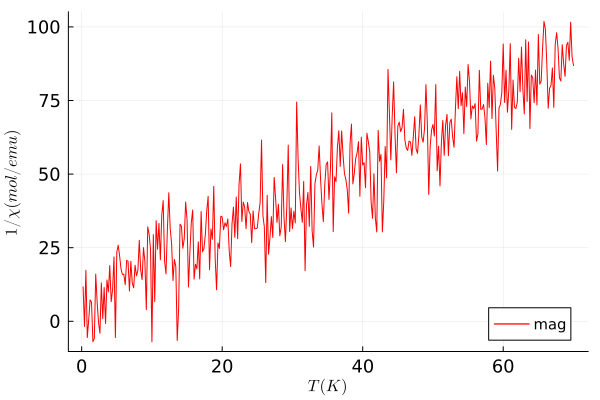

In [14]:
#chi

plot(Temp_table_chi, chi_inv_Temp_noise,label="mag",color="red")
plot!(xlabel=L"T(K)",ylabel=L"1/\chi(mol/emu)")
plot!(legendfontsize=10,xtickfont=font(12), ytickfont=font(12))
plot!(legend=:bottomright)

In [15]:
#save_path_chi = path * "data_spc_" * noise_chi * ".pdf"
#savefig(save_path_chi)

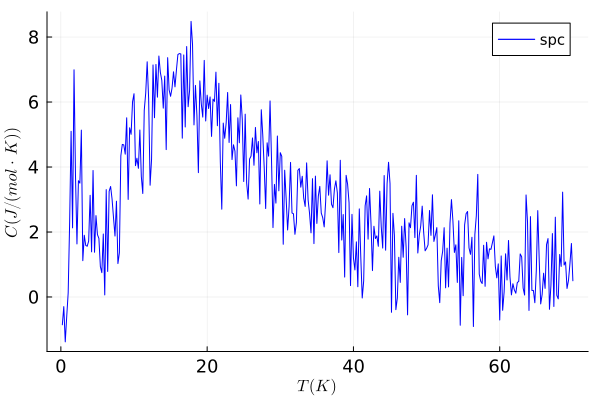

In [16]:
#spc
plot(Temp_table_spc,  SpcHeat_Temp_noise ,label="spc",color="blue")
plot!(xlabel=L"T(K)",ylabel=L"C(J/(mol \cdot K))")
plot!(legendfontsize=10,xtickfont=font(12), ytickfont=font(12))
plot!(legend=:topright)

In [17]:
#=
save_path_spc = path * "data_spc_" * string(noise_spc) * ".pdf"
savefig(save_path_spc)
=#

# データ保存

In [31]:
#=
df_spc = DataFrame(
    true_data = SpcHeat_Temp,
    noise_data = SpcHeat_Temp_noise
)
=#

In [32]:
#df_spc |> CSV.write(path * "spc_data.csv",delim=",",writeheader=true)

# hyper parameter spc

In [94]:
function para_spc()
    L = 72
    gamma = 1.4
    return L, gamma
end
L_spc, gamma_spc = para_spc()

(72, 1.4)

In [95]:
#spc_parameter_B40
function para_spc_B40()
    C = 0.05 #stepsize
    d = 0.6
    return C, d
end
C_spc_B40, d_spc_B40 = para_spc_B40()

(0.05, 0.6)

In [96]:
df_spc_para = DataFrame(
    name = ["L","gamma","C","d"],
    B40 = [L_spc, gamma_spc, C_spc_B40, d_spc_B40],
)

Row,name,B40
,String,Float64
1,L,72.0
2,gamma,1.4
3,C,0.05
4,d,0.6


In [97]:
#df_spc_para |> CSV.write(path * "spc_para.csv",delim=",",writeheader=true)

# 逆温度リスト

In [98]:
function beta_list_spc()
    beta_spc = zeros(L_spc)
    
    for i in 2:L_spc
        beta_spc[i] = gamma_spc^(i - L_spc)
    end
    
    return beta_spc
end
beta_spc = beta_list_spc()

72-element Vector{Float64}:
 0.0
 5.902520478594424e-11
 8.263528670032192e-11
 1.1568940138045069e-10
 1.6196516193263094e-10
 2.267512267056833e-10
 3.174517173879566e-10
 4.4443240434313923e-10
 6.222053660803949e-10
 8.710875125125527e-10
 1.219522517517574e-9
 1.7073315245246032e-9
 2.390264134334444e-9
 ⋮
 0.024694009309719853
 0.03457161303360779
 0.0484002582470509
 0.06776036154587126
 0.09486450616421976
 0.13281030862990764
 0.18593443208187072
 0.260308204914619
 0.36443148688046656
 0.5102040816326531
 0.7142857142857143
 1.0

In [99]:
function step_list_spc()
    #step_spc_B20 = ones(L_spc) * C_spc_B20
    step_spc_B40 = ones(L_spc) * C_spc_B40
    #step_spc_B44 = ones(L_spc) * C_spc_B44
    
    #=
    for i in 1:L_spc
        if n_spc * beta_spc[i]  > 1
            step_spc_B20[i] = C_spc_B20 / (n_spc * beta_spc[i])^d_spc_B20
        end
    end
    =#
    
    for i in 1:L_spc
        if n_spc * beta_spc[i]  > 1
            step_spc_B40[i] = C_spc_B40 / (n_spc * beta_spc[i])^d_spc_B40
        end
    end
    
    #=
    for i in 1:L_spc
        if n_spc * beta_spc[i]  > 1
            step_spc_B44[i] = C_spc_B44 / (n_spc * beta_spc[i])^d_spc_B44
        end
    end
    =#
    
    #return step_spc_B20,step_spc_B40,step_spc_B44
    return step_spc_B40
end

step_spc_B40 = step_list_spc()

72-element Vector{Float64}:
 0.05
 0.05
 0.05
 0.05
 0.05
 0.05
 0.05
 0.05
 0.05
 0.05
 0.05
 0.05
 0.05
 ⋮
 0.013708003706996175
 0.011202047033686416
 0.009154203662848312
 0.007480726018102459
 0.006113176396220011
 0.004995628173103565
 0.00408237865659126
 0.003336080052058423
 0.002726212105722471
 0.0022278339636370307
 0.0018205642030260807
 0.0014877473238306346

In [100]:
#=
df_spc_step = DataFrame(
    #B20 = step_spc_B20,
    B40 = step_spc_B40,
    #B44 = step_spc_B44
)
=#

In [101]:
#df_spc_step |> CSV.write(path * "spc_step.csv",delim=",",writeheader=true)

# 誤差関数

In [102]:
function error_spc(B40)
    error_value = sum((SpcHeat_Temp_noise - spc(Onn_make(B40))).^2)/(2*n_spc)
    return error_value
end

error_spc (generic function with 1 method)

In [103]:
#test
error_spc(B40_true)

0.555808037964293

In [104]:
function error_list_spc(B40_list)
    error_ls = zeros(L_spc)
    @threads for i in 1:L_spc
        error_ls[i] = error_spc(B40_list[i])
    end
    return error_ls
end

error_list_spc (generic function with 1 method)

# 誤差関数最小パラメータ確認

In [105]:
#B40_sample = collect(-100:0.001:100)

In [106]:
#=
error_sample_list = zeros(length(B40_sample))
@threads for i in 1:length(B40_sample)
    error_sample_list[i] = error_spc(B40_sample[i])
end
=#

In [107]:
#plot(B40_sample,error_sample_list,legend=:false)
#plot!(xlabel=L"B40",ylabel="error")

In [108]:
#savefig(path * "spc_error_B40.pdf")

In [109]:
#B40_sample = collect(0:0.0001:1)

In [110]:
#=
error_sample_list = zeros(length(B40_sample))
@threads for i in 1:length(B40_sample)
    error_sample_list[i] = error_spc(B40_sample[i])
end
=#

In [111]:
#plot(B40_sample,error_sample_list,legend=:false)
#plot!(xlabel=L"B40",ylabel="error")

In [112]:
#savefig(path * "spc_error_B40_focus.pdf")

In [113]:
para_min = B40_sample[argmin(error_sample_list)]
para_dif = abs(para_min - B40_true)
println("para_min:",para_min)
println("true_para:",B40_true)
println("dif:", para_dif)

LoadError: UndefVarError: `B40_sample` not defined

In [114]:
#=
df_spc_para_error = DataFrame(
    true_para = B40_true,
    min_para = para_min
)
=#

In [115]:
#df_spc_para_error |> CSV.write(path * "spc_para_error.csv",delim=",",writeheader=true)

# 事前分布

In [116]:
function cauchy(x,x0,gamma)
    f = (1/pi) * (gamma/((x-x0)^2+gamma^2))
    return f
end

cauchy (generic function with 1 method)

In [117]:
function prior(B40)
    prior_B40 = cauchy(B40,0,5)
    return prior_B40
end

prior (generic function with 1 method)

In [118]:
function prior_list(B40_list)
    prior_list = zeros(L_spc)
    for i in 1:L_spc
        prior_list[i] = prior(B40_list[i])
    end
    return prior_list
end

prior_list (generic function with 1 method)

# EXMC

In [119]:
# metropolis
function metropolis_spc(B40_list, saitaku)
    #更新するパラメータ
    #renew_num = rand([1,2,3])
    #renew_num_list[renew_num] += 1
    
    #copy
    #B20_proposed = B20_list
    B40_proposed = B40_list
    #B44_proposed = B44_list
    
    #=
    if renew_num == 1
        B20_proposed = B20_list + rand([-1,1],L_spc) .* step_spc_B20
    elseif renew_num == 2
        B40_proposed = B40_list + rand([-1,1],L_spc) .* step_spc_B40
    elseif renew_num == 3
        B44_proposed = B44_list + rand([-1,1],L_spc) .* step_spc_B44
    end
    =#
    
    B40_proposed = B40_list + rand(L_spc) .* rand([-1,1],L_spc) .* step_spc_B40
    
    #事前分布
    prior_ratio = prior_list(B40_proposed) ./ prior_list(B40_list)
    
    err_proposed = error_list_spc(B40_proposed)
    err_ini = error_list_spc(B40_list)
    error_dif = err_proposed - err_ini
    
    bit_vec = rand(L_spc) .< exp.(- n_spc * b_spc * beta_spc .* error_dif) .* prior_ratio
    
    for i in 1:L_spc
        if bit_vec[i] == 0 # 交換しない
            #B20_proposed[i] = B20_list[i]
            B40_proposed[i] = B40_list[i]
            #B44_proposed[i] = B44_list[i]
        else #交換
            #saitaku[i,renew_num] += 1
            saitaku[i] += 1
        end
    end
    
    #return B20_proposed, B40_proposed, B44_proposed, saitaku, err_ini, renew_num_list
    return B40_proposed, saitaku, err_ini
end

metropolis_spc (generic function with 1 method)

In [120]:
function exchange_spc(B40_list, koukann, koukann_total)

    for l in 1:L_spc-1
        #レプリカからランダムに選択
        #l = rand(collect(1:L_spc-1))
        
        beta_dif = beta_spc[l + 1] - beta_spc[l]
        error_dif = error_spc(B40_list[l + 1]) - error_spc(B40_list[l])
        v = exp(n_spc * b_spc * beta_dif * error_dif)
        u = minimum([1,v])
        items = [1,0]
        weights = [u,1 - u]
        item = sample(items, Weights(weights)) # 1で交換
        
        #交換
        if item == 1
            #B20_list[l + 1], B20_list[l] = B20_list[l], B20_list[l + 1]
            B40_list[l + 1], B40_list[l] = B40_list[l], B40_list[l + 1]
            #B44_list[l + 1], B44_list[l] = B44_list[l], B44_list[l + 1]
            koukann[l] += 1
        else
            koukann[l] += 0
        end

        #レプリカ選択の記録
        koukann_total[l] += 1
    end

    #return　B20_list, B40_list, B44_list, koukann, koukann_total
    return B40_list, koukann, koukann_total
end

exchange_spc (generic function with 1 method)

In [121]:
# exmc
function emc_spc(size_simu, frequency_exchange)
    # 初期パラメータ値
    #真値からスタート(for_check)
    #B20_start = B20_true + rand()
    #B40_start = B40_true + rand()
    #B44_start = B44_true + rand()
    
    #B20_list = B20_start * ones(L_spc)
    B40_list = B40_true *.+  5*rand(L_spc)
    #B44_list = B44_start * ones(L_spc)
    
    
    #格納用(beta=1の値を保存)
    #B20_keep = zeros(size_simu,L_spc)
    B40_keep = zeros(size_simu,L_spc)
    #B44_keep = zeros(size_simu,L_spc)
    
    #採択率,交換率記録
    #renew_num_list = zeros(3)
    #saitaku = zeros(L_spc,3)
    saitaku = zeros(L_spc)
    koukann = zeros(L_spc)
    koukann_total = zeros(L_spc)
    
    #各温度誤差関数の値記録
    error_func_list = zeros(size_simu,L_spc)
    
    # 更新
    r = Progress(size_simu; showspeed=true)

    
    for iter in 1:size_simu
        B40_list, saitaku, error_ini = metropolis_spc(B40_list, saitaku)
        error_func_list[iter, :] = error_ini
        
        if iter % frequency_exchange == 0
           B40_list, koukann, koukann_total = exchange_spc(B40_list, koukann, koukann_total)
        end
        
        #B20_keep[iter,:] = B20_list
        B40_keep[iter,:] = B40_list
        #B44_keep[iter,:] = B44_list
        
        ProgressMeter.next!(r)
    end
    
    #=
    for i in 1:3
        saitaku[:,i] = saitaku[:,i] / renew_num_list[i]
    end
    =#
    saitaku = saitaku / size_simu
    
    koukann = koukann ./ koukann_total
    
    return B40_keep, saitaku, koukann, error_func_list
end

emc_spc (generic function with 1 method)

In [122]:
mc_step = 2000
exchange_frequency = 3

3

In [123]:
B40_list_spc, saitaku_spc, koukann_spc, error_func_list_spc = emc_spc(mc_step, exchange_frequency)

Progress:   6%|█▊                         |  ETA: 0:03:46 ( 0.12  s/it)

# 温度、採択率、交換率

In [88]:
df_vin_spc = DataFrame(
    beta_temp = beta_spc,
    
    #B20 = step_spc_B20,
    #採択率_B20 = saitaku_spc[:,1],
    
    B40 = step_spc_B40,
    採択率_B40 = saitaku_spc,
    
    #B44 = step_spc_B44,
    #採択率_B44 = saitaku_spc[:,3],
    
    交換率 = koukann_spc
)

Row,beta_temp,B40,採択率_B40,交換率
,Float64,Float64,Float64,Float64
1,0.0,0.01,1.0,1.0
2,3.39406e-6,0.01,1.0,1.0
3,4.41227e-6,0.01,1.0,1.0
4,5.73596e-6,0.01,1.0,1.0
5,7.45674e-6,0.01,1.0,1.0
6,9.69377e-6,0.01,1.0,1.0
7,1.26019e-5,0.01,1.0,1.0
8,1.63825e-5,0.01,1.0,1.0
9,2.12972e-5,0.01,1.0,0.993994


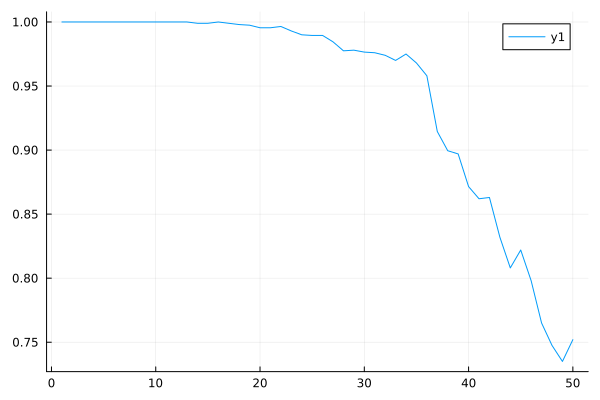

In [89]:
plot(saitaku_spc)

In [90]:
#df_vin_spc |> CSV.write(path * "vin_spc.csv",delim=",",writeheader=true)

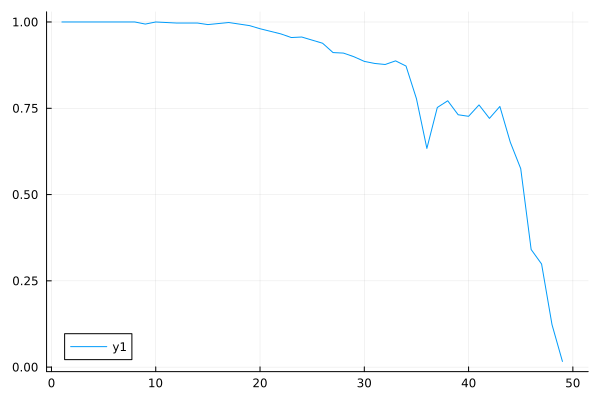

In [91]:
plot(koukann_spc)

In [69]:
#latexify(df_vin_spc; env=:table, latex=false)

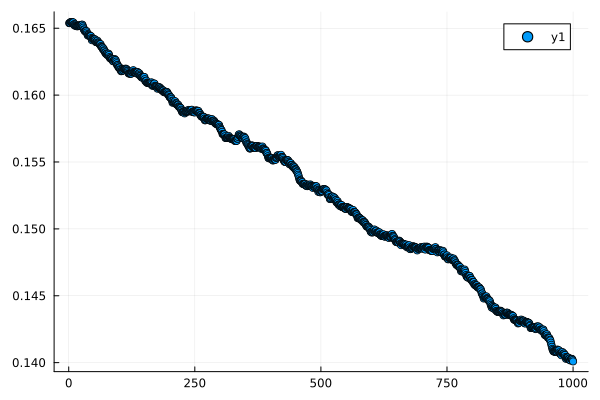

In [93]:
plot(
    B40_list_spc[1001:end,end],
    st = :scatter,
)


# 保存

In [273]:
#=
df_B40_spc = DataFrame(
    B40_list_spc, :auto
)

df_B40_spc |> CSV.write(path * "para_B40_spc.csv",delim=",",writeheader=true)
=#

"/Users/nishimurarei/home/lab/data/cubic_data/spc/1/para_B40_spc.csv"

In [274]:
#=
df_error_spc = DataFrame(
    error_func_list_spc, :auto
)
df_error_spc |> CSV.write(path * "error_spc.csv",delim=",",writeheader=true)
=#

"/Users/nishimurarei/home/lab/data/cubic_data/spc/1/error_spc.csv"

# 自由エネルギー

In [70]:
#check_free_energy
function find_free_energy_spc(error_func_list,burn_in)
    #バーンイン後のエネルギー関数抽出
    error_func_check = error_func_list[burn_in+1:end,1:end-1]
    
    #温度差
    beta_dif = beta_spc[2:end] - beta_spc[1:end-1]
    
    #温度差をかける
    for replica in 1:L_spc-1
        error_func_check[:,replica] *= beta_dif[replica]
    end
    
    #n,noiseをかける
    error_func_check *= - n_spc* b_spc
    
    #最大値取得
    error_func_check_max = zeros(L_spc-1)
    for replica in 1:L_spc-1
        error_func_check_max[replica] = maximum(error_func_check[:,replica])
    end
    
    #最大値で引いたエネルギー関数
    error_func_check_dif = copy(error_func_check)
    for replica in 1:L_spc-1
        error_func_check_dif[:,replica] = error_func_check[:,replica] .- error_func_check_max[replica]
    end
    
    #expの肩にのせる
    error_func_check_dif = exp.(error_func_check_dif)
    
    #各レプリカごとで先程の最大値を引いた差の和をとる
    sum_for_replica = zeros(L_spc-1)
    for replica in 1:L_spc-1
        sum_for_replica[replica] = sum(error_func_check_dif[:,replica])
    end
    
    #各レプリカごとで計算
    for_replica = zeros(L_spc-1)
    for replica in 1:L_spc-1
        for_replica[replica] = error_func_check_max[replica] + log(sum_for_replica[replica]) - log(size(error_func_list)[1] - burn_in)
    end
    
    #自由エネルギー
    free_energy = - n_spc/2*(log(b_spc)-log(2*pi)) - sum(for_replica)
    
    return free_energy
end

find_free_energy_spc (generic function with 1 method)

In [71]:
free_energy_spc = find_free_energy_spc(error_func_list_spc, Int(mc_step/2))
free_energy_spc

716.8172239946257

In [277]:
df_free_energy = DataFrame(自由エネルギー = free_energy_spc)
df_free_energy |> CSV.write(path * "free_energy.csv",delim=",",writeheader=true)

"/Users/nishimurarei/home/lab/data/cubic_data/spc/1/free_energy.csv"

# 自由エネルギー変化

In [278]:
list_end = Vector(10000:10000:mc_step)

10-element Vector{Int64}:
  10000
  20000
  30000
  40000
  50000
  60000
  70000
  80000
  90000
 100000

In [279]:
list_start = Vector(1:10000:mc_step)
list_start = list_start[1:length(list_end)]

10-element Vector{Int64}:
     1
 10001
 20001
 30001
 40001
 50001
 60001
 70001
 80001
 90001

In [280]:
free_energy_list = zeros(length(list_start))
for i in 1:length(list_start)
    free_energy_list[i] = find_free_energy_spc(error_func_list_spc[list_start[i]:list_end[i],:],0)
end

In [281]:
free_energy_list

10-element Vector{Float64}:
 678.9597785839703
 530.5591894225427
 509.0458242121041
 495.284606025414
 491.2990929425657
 487.9578645814825
 485.01619655485524
 483.5041541473069
 484.4343801646028
 484.5929704108021

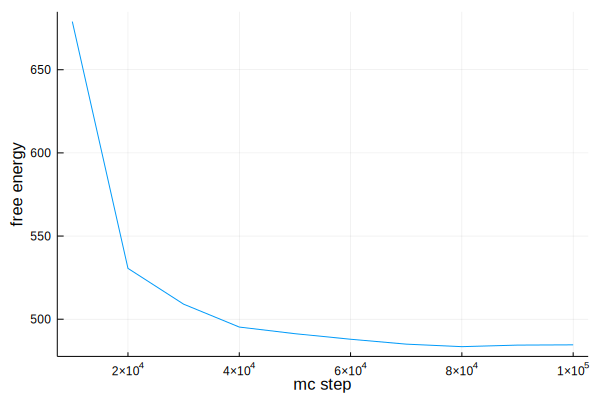

In [282]:
plot(list_end,free_energy_list)
plot!(xlabel="mc step",ylabel="free energy")
plot!(legend=false)

In [283]:
savefig(path * "free_energy_change.pdf")

# 事後分布

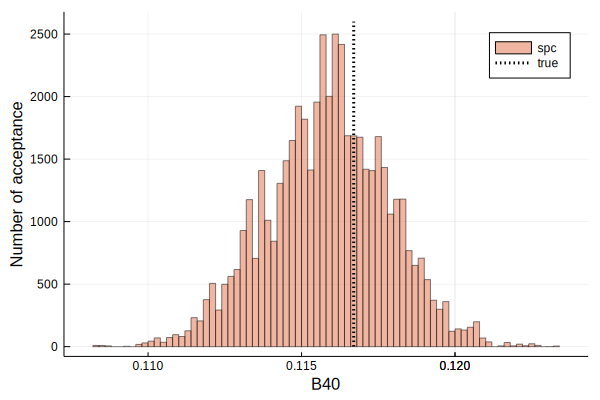

In [284]:
burn_in = Int(mc_step/2)
true_height = 2600

p1 = plot(B40_list_spc[burn_in:end,end],st=:histogram,label="spc",alpha=0.5,color=palette(:default)[2]) #yaxis=:logでlog
p1 = plot!(xlabel="B40",ylabel="Number of acceptance")
p1 = plot!(B40_true*ones(true_height),collect(1:true_height), linestyle=:dot,linewidth = 3,label="true",color=:black)

In [173]:
savefig(path * "spc_hist.pdf")

# 平均、分散

In [287]:
spc_mean = mean(B40_list_spc[burn_in:end,end])
spc_mean

0.11584854833785016

In [288]:
spc_std = std(B40_list_spc[1401:end,end])
spc_std

0.05790240621249422

In [177]:
spc_std = std(B40_list_spc[burn_in:end,end])
spc_std

1.6558061167269095e-5

In [178]:
df_mean_std = DataFrame(
    mean = spc_mean,
    std = spc_std
)

,mean,std
,Float64,Float64
1,0.1167,1.65581e-5


In [179]:
df_mean_std |> CSV.write(path * "mean_std_spc.csv",delim=",",writeheader=true)

"/Users/nishimurarei/home/lab/data/cubic_data/check/mean_std_spc.csv"

# 確認

In [199]:
spc_check = CSV.read("/Users/nishimurarei/home/lab/data/cubic_data/spc/0001/error_spc.csv", DataFrame)

,x1,x2,x3,x4,x5,x6,x7,x8,x9
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,8.17168,5.21383,4.84613,5.15214,1.90502,3.19353,5.07866,4.83883,4.84501
2,8.23039,5.21193,4.8453,5.14854,1.92056,3.10623,5.08052,4.83768,4.84412
3,8.27753,5.21383,4.84613,5.15214,1.97325,3.01519,5.07866,4.83883,4.84501
4,8.31168,4.84693,1.92056,5.21193,2.9207,5.14854,4.83768,5.07716,4.84585
5,8.27753,4.8477,1.97325,5.20996,2.82319,5.14489,4.83648,5.07608,4.84501
6,8.31168,4.84843,2.07034,5.20791,2.9207,5.14854,4.83768,5.07716,4.84585
7,8.33141,5.20996,2.21921,4.84913,3.01519,5.07866,4.83648,4.84501,5.14489
8,8.31168,5.21193,2.07034,4.84981,3.10623,5.08052,4.83768,4.84585,5.14854
9,8.33141,5.21383,2.21921,4.85045,3.01519,5.08272,4.83883,4.84666,5.14489


In [201]:
spc_check_error_func = Matrix(spc_check[:,:]);

In [204]:
L_spc = 50
find_free_energy_spc(spc_check_error_func, 50000)

-1284.2995294866498